<a href="https://colab.research.google.com/github/Kouyoumdjian/Arquivos_Vinhos/blob/main/notebook-data-analizys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conexão banco de dados PostgreSQL

In [1]:
%pip install pyspark
%pip install psycopg2-binary

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.7.3.jar

--2025-09-30 22:03:44--  https://jdbc.postgresql.org/download/postgresql-42.7.3.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1089312 (1.0M) [application/java-archive]
Saving to: ‘postgresql-42.7.3.jar.3’

postgresql-42.7.3.j 100%[===================>]   1.04M  --.-KB/s    in 0.09s   

2025-09-30 22:03:44 (10.9 MB/s) - ‘postgresql-42.7.3.jar.3’ saved [1089312/1089312]



In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PNAD Data Processing") \
    .config("spark.jars", "/content/postgresql-42.7.3.jar") \
    .getOrCreate()

In [4]:
# Credenciais do PostgreSQL
usuario_pg = "postgres"
senha_pg = "TechFiapTechFiap"
host_pg = "postgres-db.c3o4yi8i6o3f.us-east-1.rds.amazonaws.com"
porta_pg = "5432"
banco_pg = "postgres"

jdbc_url = f"jdbc:postgresql://{host_pg}:{porta_pg}/{banco_pg}"

jdbc_properties = {
    "user": usuario_pg,
    "password": senha_pg,
    "driver": "org.postgresql.Driver"
}

print(f"JDBC URL: {jdbc_url}")
print(f"JDBC Properties: {jdbc_properties}")

JDBC URL: jdbc:postgresql://postgres-db.c3o4yi8i6o3f.us-east-1.rds.amazonaws.com:5432/postgres
JDBC Properties: {'user': 'postgres', 'password': 'TechFiapTechFiap', 'driver': 'org.postgresql.Driver'}


In [5]:
query = "SELECT * FROM QUESTIONARIO"

df_spark = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", f"({query}) as custom_query") \
    .options(**jdbc_properties) \
    .load()

df_spark.printSchema()

root
 |-- ano: long (nullable = true)
 |-- v1013: long (nullable = true)
 |-- v1012: long (nullable = true)
 |-- uf: long (nullable = true)
 |-- capital: double (nullable = true)
 |-- rm_ride: double (nullable = true)
 |-- uf_nome: string (nullable = true)
 |-- sigla: string (nullable = true)
 |-- regiao: string (nullable = true)
 |-- a002: long (nullable = true)
 |-- a003: long (nullable = true)
 |-- a004: long (nullable = true)
 |-- b008: double (nullable = true)
 |-- b009a: double (nullable = true)
 |-- b009c: double (nullable = true)
 |-- b009e: double (nullable = true)
 |-- a005: long (nullable = true)
 |-- a006: double (nullable = true)
 |-- b0011: long (nullable = true)
 |-- b0012: long (nullable = true)
 |-- b0013: long (nullable = true)
 |-- b0014: long (nullable = true)
 |-- b0015: long (nullable = true)
 |-- b0016: long (nullable = true)
 |-- b0017: long (nullable = true)
 |-- b0018: long (nullable = true)
 |-- b0019: long (nullable = true)
 |-- b00110: long (nullable = true

# DataViz

In [6]:
from pyspark.sql.functions import col, when, mean, count, asc, input_file_name, lit, create_map
from itertools import chain

# 1. Selecione as colunas relevantes
cols_keep = [
    "uf","v2007","v2009","v2010",     # Demográficas
    "b002","c001",                    # Comportamento/teste
    "d0013",                          # Econômico
    "v1013",
    "b0011","b0012","b0013","b0014" # Sintomas
]
# Ensure columns exist in the dataframe
cols_keep = [c.lower() for c in cols_keep if c.lower() in df_spark.columns]
df_clean = df_spark.select(*cols_keep)
print(f"🧮 Colunas selecionadas ({len(cols_keep)}): {cols_keep}")

# 2. Crie dicionários de mapeamento
map_sim_nao = {1: "Sim", 2: "Não", 9: "Não sabe"}
map_ficou   = {1: "Sempre", 2: "Quase sempre", 3: "Às vezes", 4: "Raramente", 5: "Nunca", 9: "Não sabe"}
def dict_to_map(d): return create_map([lit(x) for x in chain(*d.items())])
m_simnao, m_ficou = dict_to_map(map_sim_nao), dict_to_map(map_ficou)

# 3. Aplique mapeamentos e crie novas colunas
sint_map = {"b0011":"FEBRE","b0012":"TOSSE","b0013":"DOR_GARGANTA","b0014":"DIFICULDADE_RESPIRAR"}
for k,v in sint_map.items():
    if k in df_clean.columns:
        df_clean = df_clean.withColumn(v, m_simnao.getItem(col(k).cast("int")))
if "c001" in df_clean.columns:
    df_clean = df_clean.withColumn("FICOU_EM_CASA", m_ficou.getItem(col("c001").cast("int")))
if "b002" in df_clean.columns:
    df_clean = df_clean.withColumn("TESTE_COVID", m_simnao.getItem(col("b002").cast("int")))
if "d0013" in df_clean.columns:
    df_clean = df_clean.withColumn("PERDA_RENDA", m_simnao.getItem(col("d0013").cast("int")))

print("✅ Limpeza + mapeamentos concluídos.")
print("👀 Amostra após mapeamentos (5 linhas):")
df_clean.limit(5).show(truncate=False)


# 4. Identifique os meses disponíveis
disp_rows = df_clean.select("v1013").distinct().orderBy(asc("v1013")).collect()
MESES_DISPONIVEIS = [r["v1013"] for r in disp_rows if r["v1013"] is not None]
print("🗓️ Meses detectados:", MESES_DISPONIVEIS)

# 5. Selecione até 3 meses para análise (substitua MESES_DESEJADOS conforme necessário ou deixe vazio para seleção automática)
MESES_DESEJADOS = [] # Example: [5, 7, 10]

def escolher_3_meses(desejados, disponiveis):
    desejados = [m for m in desejados if m]
    disp = [m for m in disponiveis if m]
    usados = []
    for m in desejados:
        if m in disp and m not in usados:
            usados.append(m)
    def prox(target, pool): return sorted(pool, key=lambda x: abs(int(x)-int(target)))
    for m in desejados:
        if len(usados)>=3: break
        if m not in usados and disp:
            cand = [x for x in disp if x not in usados]
            if cand: usados.append(prox(m, cand)[0])
    for x in disp:
        if len(usados)>=3: break
        if x not in usados: usados.append(x)
    return sorted(usados[:3]) # Sort for consistent output

MESES_USO = escolher_3_meses(MESES_DESEJADOS, MESES_DISPONIVEIS)
print(f"🎯 Meses desejados: {MESES_DESEJADOS} | Meses usados: {MESES_USO}")

# 6. Filtre o DataFrame pelos meses selecionados
df_3m = df_clean.filter(col("v1013").isin(MESES_USO))
print("📈 Contagem por MES (usados):")
df_3m.groupBy("v1013").agg(count("*").alias("qtde")).orderBy("v1013").show()
print("🔢 Total:", df_3m.count())


# 7. Calcule a prevalência de sintomas por UF
sym_cols = [c for c in ["FEBRE","TOSSE","DOR_GARGANTA","DIFICULDADE_RESPIRAR"] if c in df_3m.columns]
exprs = [mean(when(col(c)=="Sim",1).otherwise(0)).alias(f"prop_{c}") for c in sym_cols]
prev_uf_3m = df_3m.groupBy("uf").agg(*exprs)

# 9. Exiba a prevalência de sintomas por UF
print("📊 Prevalência por UF:")
prev_uf_3m.show(30, truncate=False)


🧮 Colunas selecionadas (6): ['uf', 'v1013', 'b0011', 'b0012', 'b0013', 'b0014']


/usr/local/lib/python3.12/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


✅ Limpeza + mapeamentos concluídos.
👀 Amostra após mapeamentos (5 linhas):
+---+-----+-----+-----+-----+-----+-----+-----+------------+--------------------+
|uf |v1013|b0011|b0012|b0013|b0014|FEBRE|TOSSE|DOR_GARGANTA|DIFICULDADE_RESPIRAR|
+---+-----+-----+-----+-----+-----+-----+-----+------------+--------------------+
|11 |5    |1    |1    |2    |2    |Sim  |Sim  |Não         |Não                 |
|11 |5    |1    |1    |2    |2    |Sim  |Sim  |Não         |Não                 |
|11 |5    |2    |2    |2    |2    |Não  |Não  |Não         |Não                 |
|11 |5    |2    |2    |2    |2    |Não  |Não  |Não         |Não                 |
|11 |5    |2    |2    |2    |2    |Não  |Não  |Não         |Não                 |
+---+-----+-----+-----+-----+-----+-----+-----+------------+--------------------+

🗓️ Meses detectados: [5, 7, 10]
🎯 Meses desejados: [] | Meses usados: [5, 7, 10]
📈 Contagem por MES (usados):
+-----+------+
|v1013|  qtde|
+-----+------+
|    5|349306|
|    7|384166|
|

In [8]:
# ================================================
# MEU TRECHO – Medalhão + padrões + Postgres (SILVER/GOLD)
# Requisitos prévios: spark, jdbc_url, jdbc_properties, df_clean (do bloco anterior)
# Usa df_3m/prev_uf_3mes se já existirem; senão constrói a partir do df_clean
# ================================================
from pyspark.sql.functions import (
    col, upper, trim, when, lit, current_timestamp,
    avg as f_avg, count as f_count
)
from pyspark.sql.types import IntegerType, StringType

# ---- Pré-checagem de requisitos ----
try:
    spark
    jdbc_url
    jdbc_properties
    df_clean
except NameError as e:
    raise RuntimeError(
        "Pré-requisito ausente: garanta que o bloco da colega rodou (spark/jdbc_url/jdbc_properties/df_clean)."
    ) from e

# ---- helpers ----
def exists(df, c):
    return c in df.columns

def cast_if_exists(df, colname, dtype, normalize_str=False):
    if exists(df, colname):
        expr = col(colname).cast(dtype)
        if normalize_str:
            expr = upper(trim(expr))
        return df.withColumn(colname, expr)
    return df

# ------------------------------------------------
# 1) SILVER: padronização (≤20 questionamentos) + derivadas legíveis
# ------------------------------------------------
quest_cols = [c for c in [
    "uf","v2007","v2009","v2010","v1013",      # demográficas + mês
    "b0011","b0012","b0013","b0014",          # sintomas (códigos)
    "b002","c001","d0013"                     # teste, comportamento, econômico
] if exists(df_clean, c)]

pretty_cols = [c for c in [
    "FEBRE","TOSSE","DOR_GARGANTA","DIFICULDADE_RESPIRAR",
    "FICOU_EM_CASA","TESTE_COVID","PERDA_RENDA"
] if exists(df_clean, c)]

silver = df_clean.select(*(quest_cols + pretty_cols))

# renomear p/ padrão (mais legível)
renames = {
    "uf":"UF", "v2007":"SEXO", "v2009":"IDADE", "v2010":"RACA_COR", "v1013":"MES",
    "b0011":"B0011","b0012":"B0012","b0013":"B0013","b0014":"B0014",
    "b002":"B002","c001":"C001","d0013":"D0013"
}
for a,b in renames.items():
    if exists(silver, a) and a != b:
        silver = silver.withColumnRenamed(a,b)

# tipos/normalização
silver = cast_if_exists(silver, "UF", StringType(), normalize_str=True)
silver = cast_if_exists(silver, "SEXO", IntegerType())
silver = cast_if_exists(silver, "IDADE", IntegerType())
silver = cast_if_exists(silver, "RACA_COR", IntegerType())
silver = cast_if_exists(silver, "MES", IntegerType())

# metadados
silver = silver.withColumn("ORIGEM", lit("postgres_rds.QUESTIONARIO"))
silver = silver.withColumn("CARGA_TS", current_timestamp())

print("✅ SILVER pronto (amostra):")
silver.limit(5).show(truncate=False)
print("📚 Colunas do SILVER:", silver.columns)

# ------------------------------------------------
# 2) GOLD – fato (3 meses) + agregado por UF
#    • usa df_3m/prev_uf_3m se já existirem
#    • senão, constrói a partir do SILVER
# ------------------------------------------------
# fato (linhas dos 3 meses)
try:
    df3m = df_3m
except NameError:
    if not exists(silver, "MES"):
        # tentar renomear se veio como v1013
        if exists(silver, "v1013"):
            silver = silver.withColumnRenamed("v1013", "MES").withColumn("MES", col("MES").cast(IntegerType()))
        else:
            raise RuntimeError("Não encontrei 'MES'/'v1013' para montar o GOLD fato.")
    # top-3 meses mais frequentes
    meses_usados = [r["MES"] for r in silver.groupBy("MES").agg(f_count("*").alias("qt")) \
                                   .orderBy(col("qt").desc()).limit(3).collect()]
    meses_usados = [m for m in meses_usados if m is not None]
    df3m = silver.filter(col("MES").isin(meses_usados))

# normalização garantida em df3m
if exists(df3m, "v1013") and not exists(df3m, "MES"):
    df3m = df3m.withColumnRenamed("v1013", "MES")
df3m = cast_if_exists(df3m, "MES", IntegerType())
if exists(df3m, "uf") and not exists(df3m, "UF"):
    df3m = df3m.withColumnRenamed("uf","UF")
df3m = cast_if_exists(df3m, "UF", StringType(), normalize_str=True)

print("\n🎯 GOLD fato – contagem por MES:")
if exists(df3m, "MES"):
    df3m.groupBy("MES").agg(f_count("*").alias("qtde")).orderBy("MES").show()
else:
    print("  (sem coluna MES)")

# agregado por UF
try:
    prev_uf = prev_uf_3m
    if exists(prev_uf, "uf") and not exists(prev_uf, "UF"):
        prev_uf = prev_uf.withColumnRenamed("uf","UF")
except NameError:
    symptom_cols = [c for c in ["FEBRE","TOSSE","DOR_GARGANTA","DIFICULDADE_RESPIRAR"] if exists(df3m, c)]
    agg_exprs = [f_avg(when(col(c)=="Sim",1).otherwise(0)).alias(f"prop_{c}") for c in symptom_cols] \
                if symptom_cols else [f_count("*").alias("qtde")]
    prev_uf = df3m.groupBy("UF").agg(*agg_exprs)

print("📊 GOLD agregado por UF (amostra):")
prev_uf.show(20, truncate=False)

# ------------------------------------------------
# 3) Escrita no Postgres (overwrite)
# ------------------------------------------------
t_silver = "public.pnad_silver"
t_fato   = "public.pnad_curado_3meses"
t_agg    = "public.prev_sintomas_uf_3meses"

for (name, dframe) in [(t_silver, silver), (t_fato, df3m), (t_agg, prev_uf)]:
    (
        dframe.write
        .format("jdbc")
        .option("url", jdbc_url)
        .option("dbtable", name)
        .options(**jdbc_properties)
        .mode("overwrite")
        .save()
    )
    print(f"✅ Gravado no Postgres: {name}")

# ------------------------------------------------
# 4) Checks rápidos + análises pra apresentação
# ------------------------------------------------
print("\n🧪 Nulos por coluna (SILVER):")
nulls = silver.select([f_count(when(col(c).isNull(), c)).alias(c) for c in silver.columns])
nulls.show(truncate=False)

if exists(df3m, "FEBRE"):
    print("\n🔥 Top 10 UFs por prevalência de FEBRE:")
    top_febre = df3m.groupBy("UF") \
                    .agg(f_avg(when(col("FEBRE")=="Sim",1).otherwise(0)).alias("prop_febre")) \
                    .orderBy(col("prop_febre").desc())
    top_febre.show(10, truncate=False)

if exists(df3m, "FICOU_EM_CASA"):
    print("\n🏠 Distribuição do isolamento (FICOU_EM_CASA):")
    dist_iso = df3m.groupBy("FICOU_EM_CASA").agg(f_count("*").alias("qtd")).orderBy(col("qtd").desc())
    dist_iso.show(truncate=False)

if exists(df3m, "PERDA_RENDA"):
    print("\n💸 Proporção de PERDA_RENDA:")
    pr = df3m.agg(f_avg(when(col("PERDA_RENDA")=="Sim",1).otherwise(0)).alias("prop_perda_renda"))
    pr.show(truncate=False)

print("\n✅ FIM — Medalhão concluído (SILVER/GOLD) e tabelas gravadas no Postgres.")


✅ SILVER pronto (amostra):
+---+---+-----+-----+-----+-----+-----+-----+------------+--------------------+-------------------------+--------------------------+
|UF |MES|B0011|B0012|B0013|B0014|FEBRE|TOSSE|DOR_GARGANTA|DIFICULDADE_RESPIRAR|ORIGEM                   |CARGA_TS                  |
+---+---+-----+-----+-----+-----+-----+-----+------------+--------------------+-------------------------+--------------------------+
|11 |5  |1    |1    |2    |2    |Sim  |Sim  |Não         |Não                 |postgres_rds.QUESTIONARIO|2025-09-30 22:14:13.308078|
|11 |5  |1    |1    |2    |2    |Sim  |Sim  |Não         |Não                 |postgres_rds.QUESTIONARIO|2025-09-30 22:14:13.308078|
|11 |5  |2    |2    |2    |2    |Não  |Não  |Não         |Não                 |postgres_rds.QUESTIONARIO|2025-09-30 22:14:13.308078|
|11 |5  |2    |2    |2    |2    |Não  |Não  |Não         |Não                 |postgres_rds.QUESTIONARIO|2025-09-30 22:14:13.308078|
|11 |5  |2    |2    |2    |2    |Não  |Não

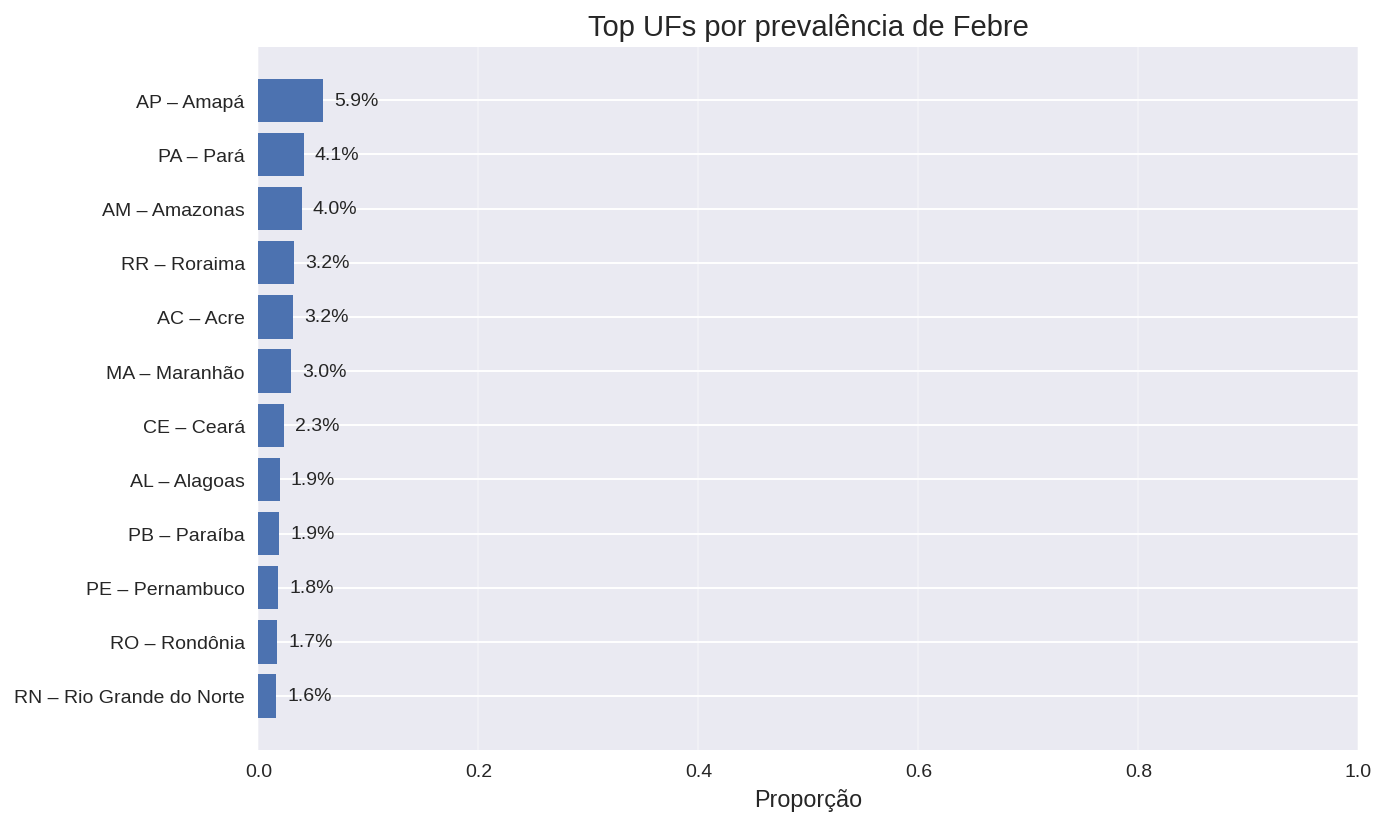

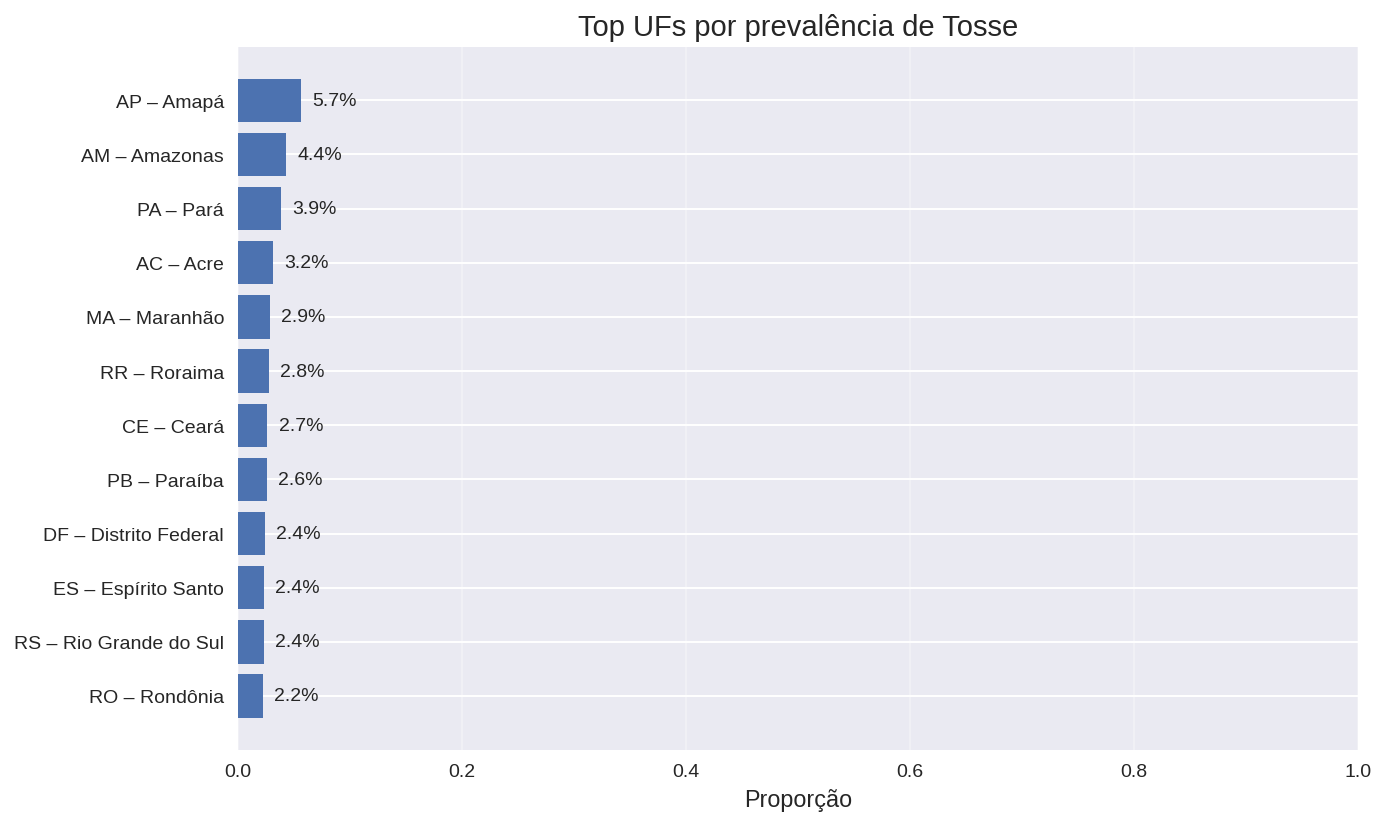

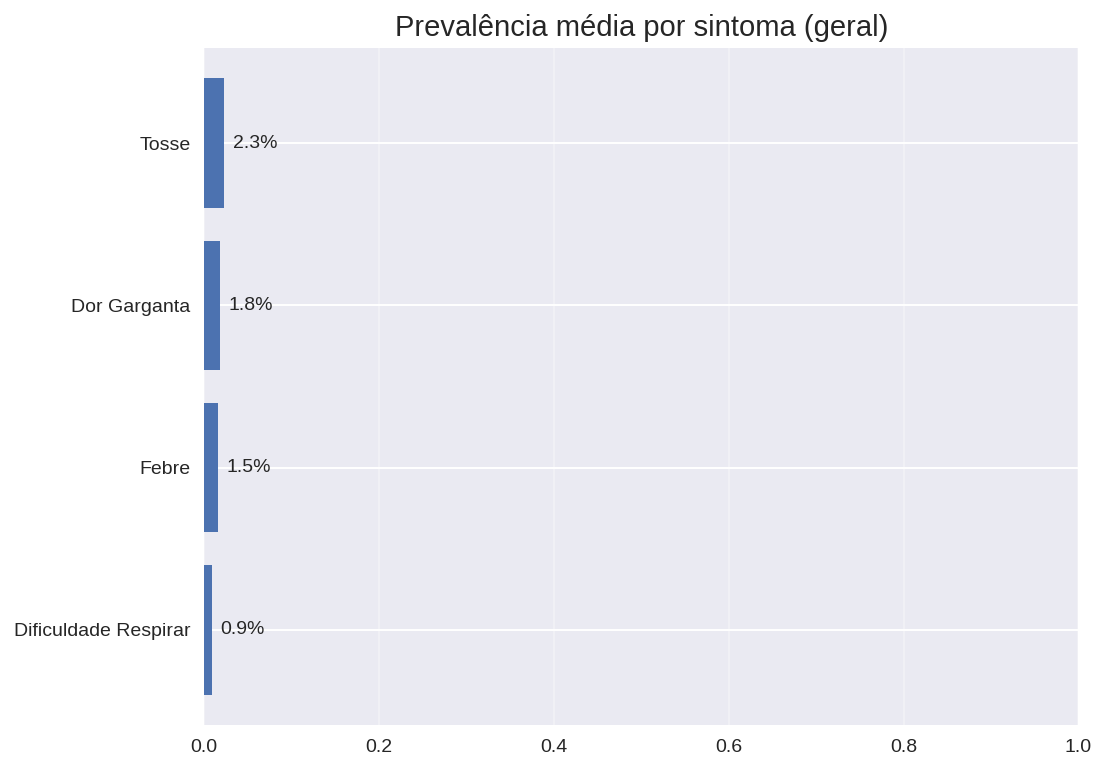

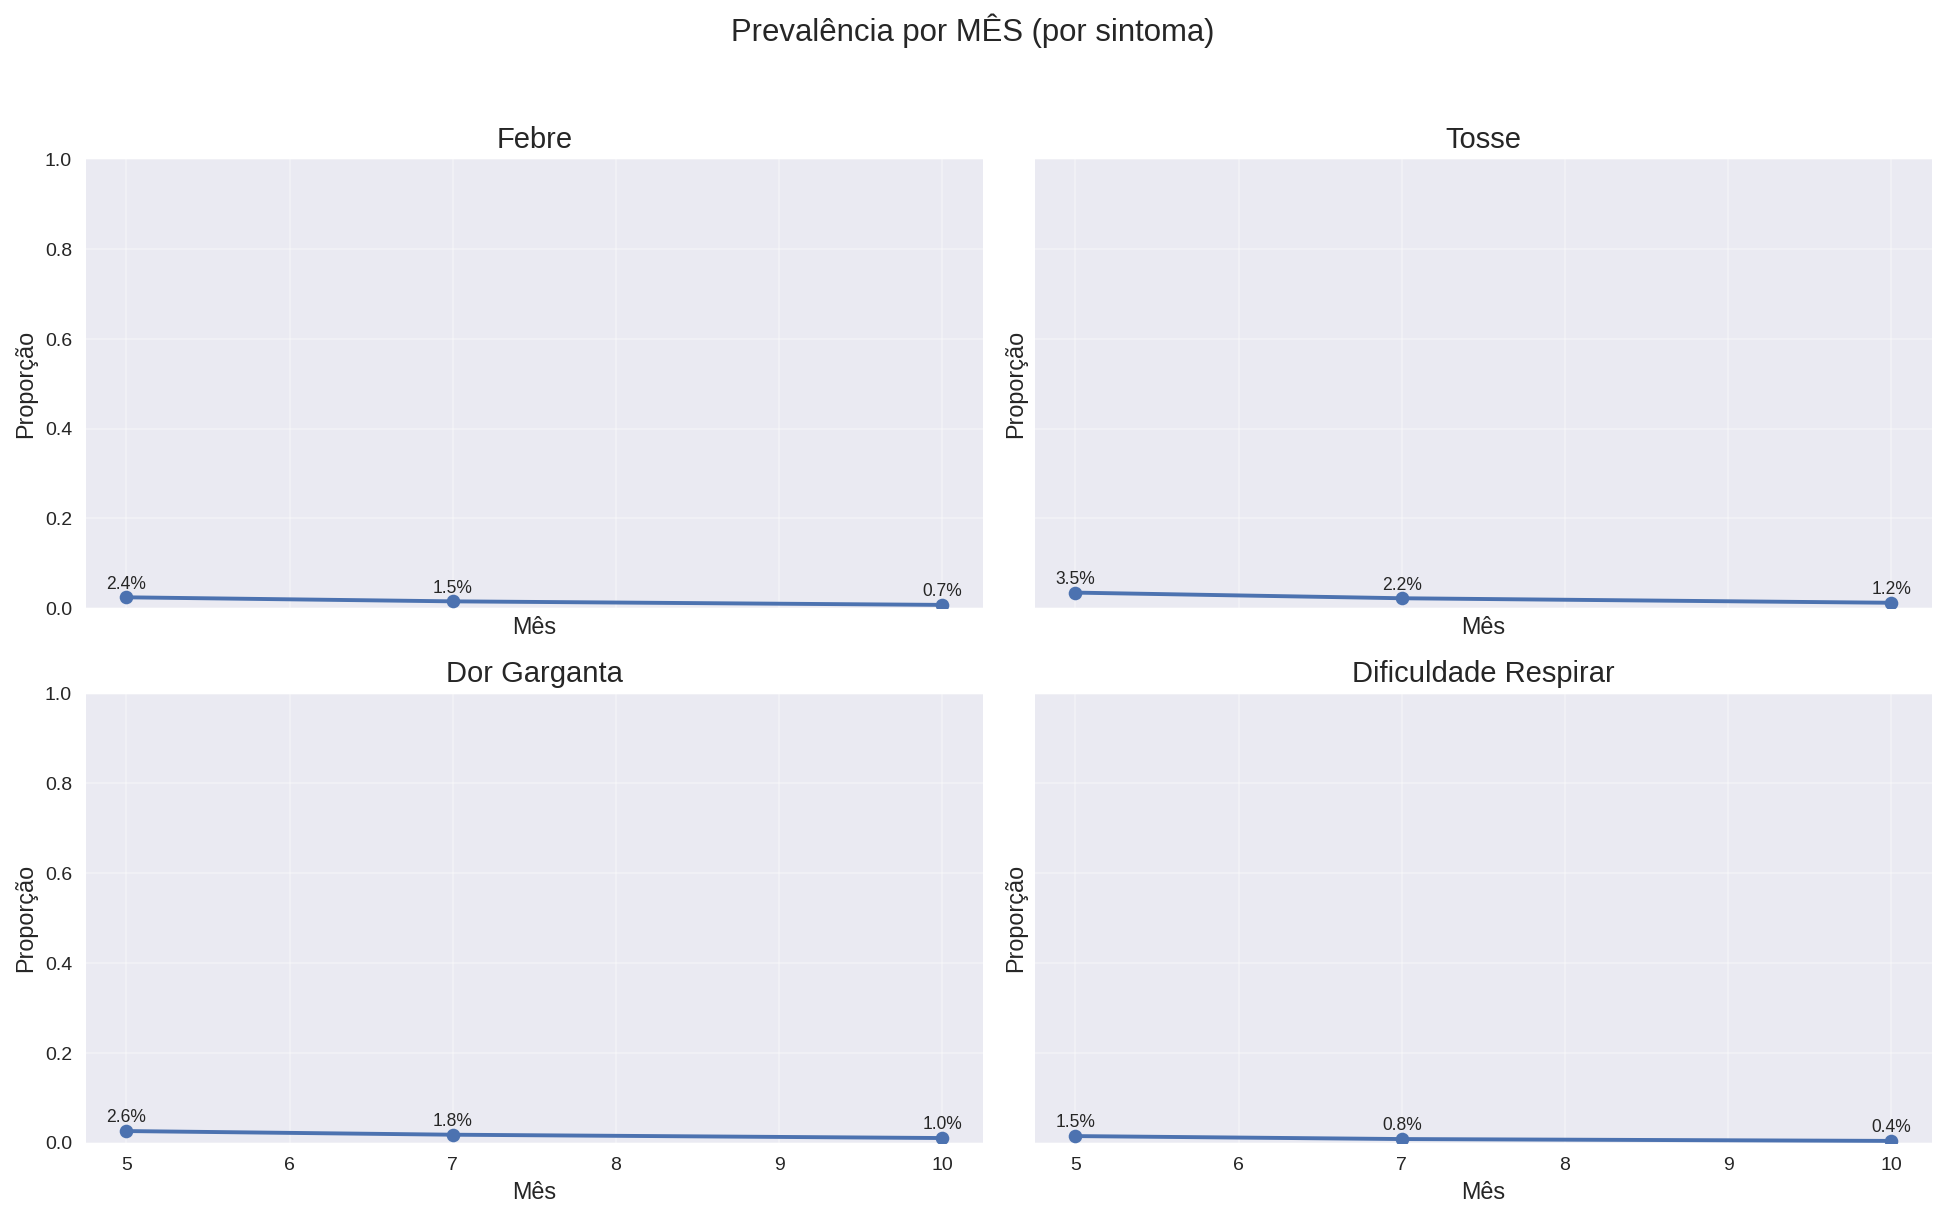

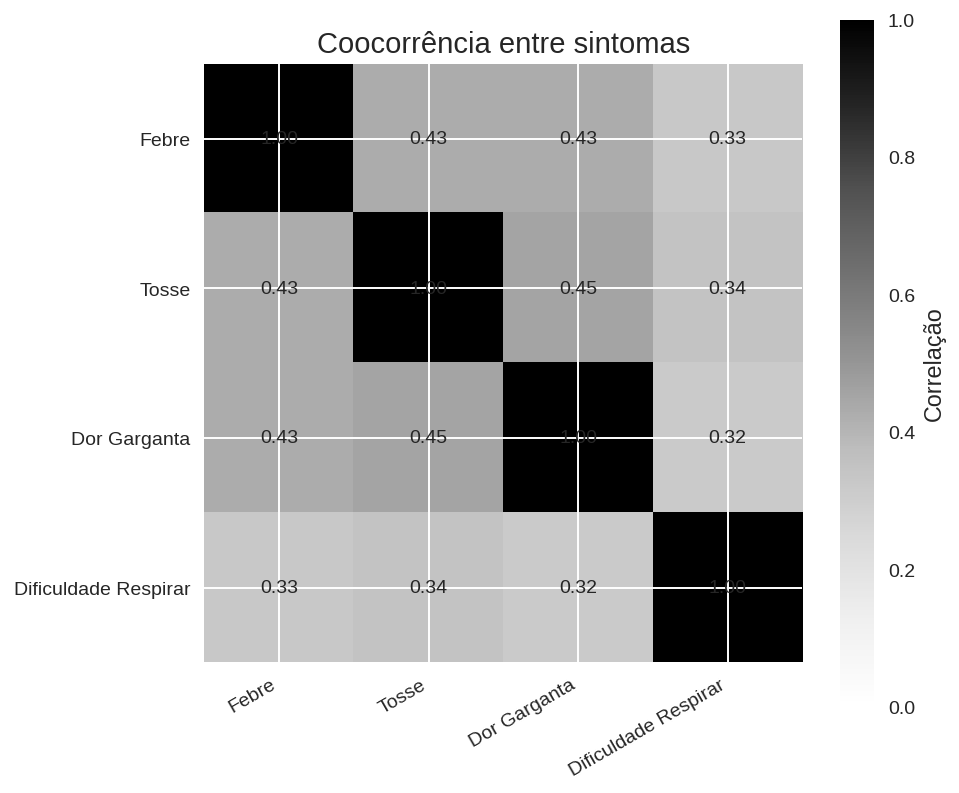

ℹ️ Sem FICOU_EM_CASA — gráfico de isolamento pulado.
ℹ️ Coluna IDADE ausente — histograma pulado.


In [14]:
# ===========================================================
# Visualizações PNAD — bloco único (UF como "SP – São Paulo")
# Lê Postgres: public.pnad_curado_3meses (fato) e prev_sintomas_uf_3meses (agregado)
# ===========================================================
!pip -q install psycopg2-binary sqlalchemy pandas matplotlib numpy

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

# ---------- Credenciais ----------
HOST = "postgres-db.c3o4yi8i6o3f.us-east-1.rds.amazonaws.com"
PORT = 5432
DB   = "postgres"
USER = "postgres"
PWD  = "TechFiapTechFiap"

ENGINE = create_engine(f"postgresql+psycopg2://{USER}:{PWD}@{HOST}:{PORT}/{DB}?sslmode=require")

# ---------- Helpers de leitura e padronização ----------
def read_table(name):
    try:
        with ENGINE.connect() as con:
            return pd.read_sql(text(f"SELECT * FROM {name}"), con)
    except Exception as e:
        print(f"⚠️ Não consegui ler {name}: {e}")
        return None

def up(df):
    return df.rename(columns=str.upper)

def ensure_mes(df):
    if df is None: return None
    if "MES" not in df.columns and "V1013" in df.columns:
        df = df.rename(columns={"V1013":"MES"})
    if "MES" in df.columns:
        df = df.copy()
        df["MES"] = pd.to_numeric(df["MES"], errors="coerce")
        df = df.dropna(subset=["MES"])
        df["MES"] = df["MES"].astype(int)
    return df

def to01(series):  # "Sim"/"Não" -> 1/0
    s = series.astype(str).str.strip().str.upper()
    return (s == "SIM").astype(float)

# ---------- Lê tabelas ----------
df_fato = read_table("public.pnad_curado_3meses")
df_prev = read_table("public.prev_sintomas_uf_3meses")

if df_fato is not None: df_fato = up(df_fato)
if df_prev is not None: df_prev = up(df_prev)
df_fato = ensure_mes(df_fato)

# ---------- Mapeamento UF: código/sigla -> "SIGLA – Nome" ----------
IBGE_UF = {
    11:("RO","Rondônia"), 12:("AC","Acre"), 13:("AM","Amazonas"), 14:("RR","Roraima"),
    15:("PA","Pará"), 16:("AP","Amapá"), 17:("TO","Tocantins"),
    21:("MA","Maranhão"), 22:("PI","Piauí"), 23:("CE","Ceará"), 24:("RN","Rio Grande do Norte"),
    25:("PB","Paraíba"), 26:("PE","Pernambuco"), 27:("AL","Alagoas"), 28:("SE","Sergipe"), 29:("BA","Bahia"),
    31:("MG","Minas Gerais"), 32:("ES","Espírito Santo"), 33:("RJ","Rio de Janeiro"), 35:("SP","São Paulo"),
    41:("PR","Paraná"), 42:("SC","Santa Catarina"), 43:("RS","Rio Grande do Sul"),
    50:("MS","Mato Grosso do Sul"), 51:("MT","Mato Grosso"), 52:("GO","Goiás"), 53:("DF","Distrito Federal")
}
SIGLA_NOME = {v[0]: v[1] for v in IBGE_UF.values()}

def uf_sigla_nome(x):
    if pd.isna(x): return (np.nan, np.nan, np.nan)
    s = str(x).strip().upper()
    # já for sigla
    if s in SIGLA_NOME:
        nome = SIGLA_NOME[s]
        return (s, nome, f"{s} – {nome}")
    # tentar código numérico
    try:
        n = int(float(s))
        if n in IBGE_UF:
            sigla, nome = IBGE_UF[n]
            return (sigla, nome, f"{sigla} – {nome}")
    except:
        pass
    # fallback
    return (s, s, s)

for df in [df_fato, df_prev]:
    if df is not None and "UF" in df.columns:
        tup = df["UF"].apply(uf_sigla_nome)
        df["UF_SIGLA"] = tup.apply(lambda t: t[0])
        df["UF_NOME"]  = tup.apply(lambda t: t[1])
        df["UF_LABEL"] = tup.apply(lambda t: t[2])

# ---------- Config visual ----------
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ---------- Sintomas disponíveis ----------
SINTOMAS = [c for c in ["FEBRE","TOSSE","DOR_GARGANTA","DIFICULDADE_RESPIRAR"]
            if df_fato is not None and c in df_fato.columns]

# ===========================================================
# 1) Top-12 UFs por FEBRE (e por TOSSE se existir)
# ===========================================================
def plot_top_ufs(df, coluna_sintoma, titulo_extra=""):
    if df is None or "UF_LABEL" not in df.columns or coluna_sintoma not in df.columns:
        print(f"ℹ️ Sem dados para Top UFs ({coluna_sintoma})."); return
    tmp = df[["UF_LABEL", coluna_sintoma]].dropna()
    tmp[coluna_sintoma] = to01(tmp[coluna_sintoma])
    rank = tmp.groupby("UF_LABEL")[coluna_sintoma].mean().sort_values(ascending=False).head(12)
    if rank.empty:
        print(f"ℹ️ Rank vazio ({coluna_sintoma})."); return
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(rank.index, rank.values)
    ax.invert_yaxis()
    ax.set_title(f"Top UFs por prevalência de {coluna_sintoma.replace('_',' ').title()} {titulo_extra}".strip())
    ax.set_xlabel("Proporção")
    ax.set_xlim(0, 1)
    for i, v in enumerate(rank.values):
        ax.text(v + 0.01, i, f"{v:.1%}", va="center")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()

if df_fato is not None:
    if "FEBRE" in SINTOMAS: plot_top_ufs(df_fato, "FEBRE")
    if "TOSSE" in SINTOMAS: plot_top_ufs(df_fato, "TOSSE")

# ===========================================================
# 2) Prevalência geral por sintoma (barra horizontal)
# ===========================================================
if df_fato is not None and SINTOMAS:
    tmp = df_fato[SINTOMAS].copy()
    for c in SINTOMAS: tmp[c] = to01(tmp[c])
    prev = tmp.mean().sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(8, 4 + 0.4*len(prev)))
    ax.barh([s.replace("_"," ").title() for s in prev.index], prev.values)
    ax.set_title("Prevalência média por sintoma (geral)")
    ax.set_xlim(0, 1)
    for i, v in enumerate(prev.values):
        ax.text(v + 0.01, i, f"{v:.1%}", va="center")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()
else:
    print("ℹ️ Sem sintomas para o gráfico geral.")

# ===========================================================
# 3) Série temporal por MÊS (small multiples por sintoma)
# ===========================================================
def ensure_mes_numeric(df):
    if df is None or "MES" not in df.columns: return None
    d = df.copy()
    d["MES"] = pd.to_numeric(d["MES"], errors="coerce")
    d = d.dropna(subset=["MES"])
    d["MES"] = d["MES"].astype(int)
    return d

if df_fato is not None and "MES" in df_fato.columns and SINTOMAS:
    d = ensure_mes_numeric(df_fato)
    if d is not None:
        tmp = d[["MES"] + SINTOMAS].copy()
        for c in SINTOMAS: tmp[c] = to01(tmp[c])
        linha = tmp.groupby("MES")[SINTOMAS].mean().sort_index()

        cols = 2
        rows = int(np.ceil(len(SINTOMAS)/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(14, 4.2*rows), sharex=True, sharey=True)
        axes = np.array(axes).reshape(-1)

        for i, c in enumerate(SINTOMAS):
            ax = axes[i]
            ax.plot(linha.index, linha[c], marker="o", linewidth=2)
            ax.set_title(c.replace("_"," ").title())
            ax.set_ylim(0, 1)
            ax.set_xlabel("Mês"); ax.set_ylabel("Proporção")
            ax.grid(alpha=0.3)
            for x, y in zip(linha.index, linha[c].values):
                ax.text(x, y + 0.02, f"{y:.1%}", ha="center", fontsize=9)
        for j in range(i+1, len(axes)): fig.delaxes(axes[j])
        fig.suptitle("Prevalência por MÊS (por sintoma)", y=1.03, fontsize=16)
        plt.tight_layout(); plt.show()
else:
    print("ℹ️ Sem MES/sintomas suficientes para série temporal.")

# ===========================================================
# 4) Heatmap de coocorrência entre sintomas
# ===========================================================
if df_fato is not None and len(SINTOMAS) >= 2:
    binarized = pd.DataFrame({c: to01(df_fato[c]) for c in SINTOMAS}).dropna()
    if not binarized.empty:
        corr = binarized.corr()
        fig, ax = plt.subplots(figsize=(7, 6))
        im = ax.imshow(corr, vmin=0, vmax=1)
        labels = [s.replace("_"," ").title() for s in SINTOMAS]
        ax.set_xticks(range(len(SINTOMAS))); ax.set_yticks(range(len(SINTOMAS)))
        ax.set_xticklabels(labels, rotation=30, ha="right"); ax.set_yticklabels(labels)
        for i in range(len(SINTOMAS)):
            for j in range(len(SINTOMAS)):
                ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center")
        fig.colorbar(im, ax=ax, label="Correlação")
        ax.set_title("Coocorrência entre sintomas")
        plt.tight_layout(); plt.show()
    else:
        print("ℹ️ Poucos dados para heatmap.")
else:
    print("ℹ️ Heatmap pulado (precisa de ≥2 sintomas).")

# ===========================================================
# 5) (Se existir) Isolamento e Idade
# ===========================================================
if df_fato is not None and "FICOU_EM_CASA" in df_fato.columns:
    ordem = ["Sempre","Quase sempre","Às vezes","Raramente","Nunca","Sem informação"]
    dist = df_fato["FICOU_EM_CASA"].fillna("Sem informação").value_counts()
    dist = dist.reindex(ordem, fill_value=0)
    total = dist.sum()
    perc = (dist / total * 100).round(1)
    fig, ax = plt.subplots(figsize=(10,6))
    bars = ax.bar(dist.index.astype(str), dist.values, width=0.6)
    ax.set_title("Distribuição de Isolamento (FICOU_EM_CASA)")
    ax.set_ylabel("Contagem")
    ax.grid(axis="y", alpha=0.3)
    for rect, p in zip(bars, perc.values):
        ax.text(rect.get_x()+rect.get_width()/2, rect.get_height()+max(dist.values)*0.01, f"{p:.1f}%", ha="center", va="bottom")
    plt.xticks(rotation=12)
    plt.tight_layout(); plt.show()
else:
    print("ℹ️ Sem FICOU_EM_CASA — gráfico de isolamento pulado.")

if df_fato is not None and "IDADE" in df_fato.columns:
    serie = pd.to_numeric(df_fato["IDADE"], errors="coerce").dropna()
    if not serie.empty:
        fig, ax = plt.subplots(figsize=(10,6))
        ax.hist(serie, bins=30)
        ax.set_title("Distribuição de Idade")
        ax.set_xlabel("Idade")
        ax.set_ylabel("Frequência")
        ax.grid(alpha=0.25)
        plt.tight_layout(); plt.show()
    else:
        print("ℹ️ Sem valores numéricos válidos em IDADE.")
else:
    print("ℹ️ Coluna IDADE ausente — histograma pulado.")
